In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("politician_dataset.csv")
print(data.head())

# for mapping the label true or false
label_mapping = {
  'FALSE': 0,
    'half-true': 0,
    'mostly-true': 1,
    'mostly-false': 0,
    'TRUE': 1,
    'pants-fire': 0,
}

data['label'] = data['verdict'].map(label_mapping)

print("Label Distribution:\n", data['label'].value_counts())

data.to_csv("cleaned_politifact_data.csv", index=False)





       verdict statement_originator  \
0         TRUE         Barack Obama   
1        FALSE         Donald Trump   
2        FALSE         Donald Trump   
3  mostly-true            Joe Biden   
4    half-true         Donald Trump   

                                           statement statement_date  \
0  John McCain opposed bankruptcy protections for...      6/11/2008   
1  With voting by mail, "you get thousands and th...       4/7/2020   
2  Says he is "cutting illegal immigration in half."     10/30/2019   
3  "All the billionaires in America, their net wo...      9/21/2020   
4  Says that in polls about 2016 candidate leader...      11/8/2015   

  statement_source        factchecker factcheck_date  \
0           speech  Adriel Bettelheim      6/16/2008   
1             news     Louis Jacobson       4/9/2020   
2         campaign    Miriam Valverde     10/31/2019   
3           speech      Nusaiba Mizan     10/12/2020   
4           speech     Lauren Carroll      11/8/2015   

 

**Cleaning Data**

In [3]:
import string

#function for cleaning the text
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    return text


data['cleaned_statement'] = data['statement'].apply(preprocess_text)

#print(data.head())


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_statement'], data['label'], test_size=0.1, random_state=42)

print(len(X_train),len(X_test))


2586 288


**Baseline Model**

baseline model
              precision    recall  f1-score   support

           0       0.74      0.97      0.84       206
           1       0.61      0.13      0.22        82

    accuracy                           0.73       288
   macro avg       0.67      0.55      0.53       288
weighted avg       0.70      0.73      0.66       288



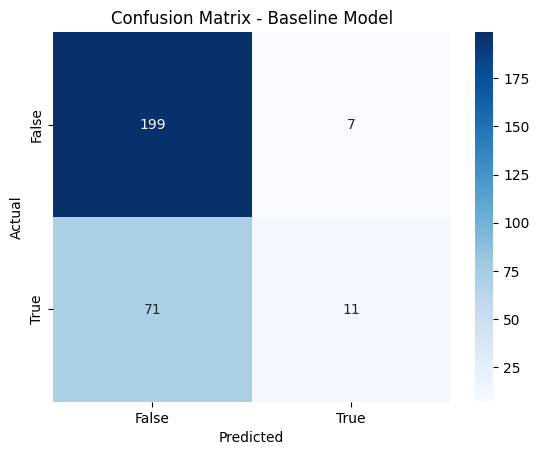

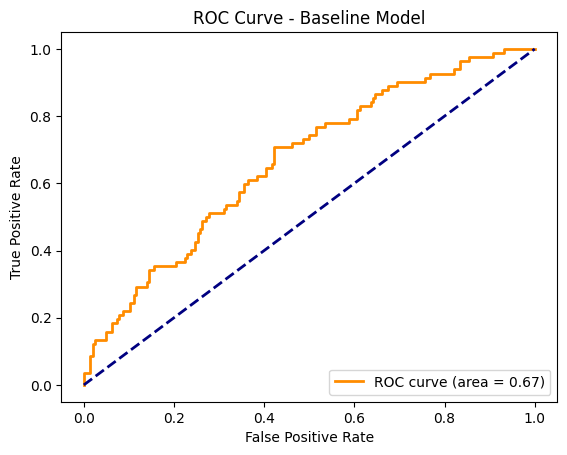

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#logistic reg.
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train_tfidf, y_train)

y_pred_baseline = lr_model.predict(X_test_tfidf)

print("baseline model")
print(classification_report(y_test, y_pred_baseline))

cm = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.title("Confusion Matrix - Baseline Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_pred_proba = lr_model.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("ROC Curve - Baseline Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [14]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#tokenize data for BERT
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128, return_tensors="pt")

class FactCheckDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = FactCheckDataset(train_encodings, y_train.tolist())
test_dataset = FactCheckDataset(test_encodings, y_test.tolist())

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10
)

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

bert_model.save_pretrained('./fact_check_model_bert')
tokenizer.save_pretrained('./fact_check_model_bert')



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.548700,0.578471
2,0.463900,0.596440
3,0.264600,0.785330


('./fact_check_model_bert/tokenizer_config.json',
 './fact_check_model_bert/special_tokens_map.json',
 './fact_check_model_bert/vocab.txt',
 './fact_check_model_bert/added_tokens.json')

Experimental Model Performance:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79       206
           1       0.48      0.50      0.49        82

    accuracy                           0.70       288
   macro avg       0.64      0.64      0.64       288
weighted avg       0.71      0.70      0.71       288



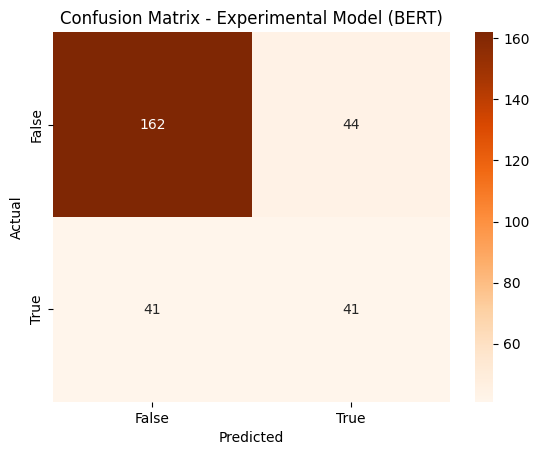

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

bert_model = BertForSequenceClassification.from_pretrained('./fact_check_model_bert')
tokenizer = BertTokenizer.from_pretrained('./fact_check_model_bert')

test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128, return_tensors="pt")


outputs = bert_model(**test_encodings)
predictions = torch.argmax(outputs.logits, dim=1).numpy()

print("Experimental Model Performance:")
print(classification_report(y_test, predictions))

cm_bert = confusion_matrix(y_test, predictions)
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Oranges", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.title("Confusion Matrix - Experimental Model (BERT)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Model Evaluate**

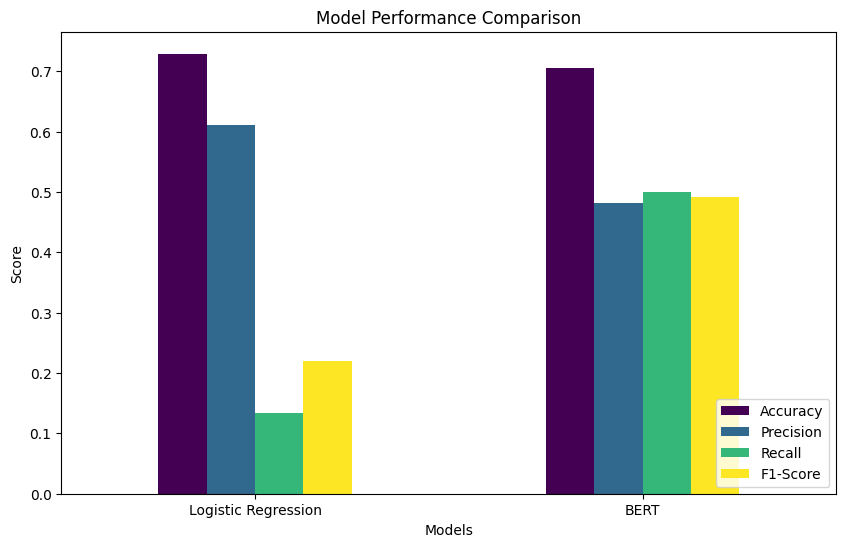

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

#logistic reg matrix.
lr_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_baseline),
    "Precision": precision_score(y_test, y_pred_baseline),
    "Recall": recall_score(y_test, y_pred_baseline),
    "F1-Score": f1_score(y_test, y_pred_baseline),
}

bert_metrics = {
    "Accuracy": accuracy_score(y_test, predictions),
    "Precision": precision_score(y_test, predictions),
    "Recall": recall_score(y_test, predictions),
    "F1-Score": f1_score(y_test, predictions),
}

metrics_df = pd.DataFrame([lr_metrics, bert_metrics], index=["Logistic Regression", "BERT"])

metrics_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Models")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()


fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

outputs = bert_model(**test_encodings)
y_pred_proba_bert = torch.softmax(outputs.logits, dim=1)[:, 1].detach().numpy()
fpr_bert, tpr_bert, _ = roc_curve(y_test, y_pred_proba_bert)
roc_auc_bert = auc(fpr_bert, tpr_bert)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})", color='blue', lw=2)
plt.plot(fpr_bert, tpr_bert, label=f"BERT (AUC = {roc_auc_bert:.2f})", color='red', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# confustion mat plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"], ax=axes[0])
axes[0].set_title("Confusion Matrix - Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Oranges", xticklabels=["False", "True"], yticklabels=["False", "True"], ax=axes[1])
axes[1].set_title("Confusion Matrix - BERT")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()
